In [171]:
import sys
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [167]:
pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', None)

In [85]:
genemap2 = pd.read_csv("genemap2.txt", sep="\t", comment="#", header=None)

In [86]:
genemap2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,chr1,0,123400000,1p,NaN,606788,ANON1,"Anorexia nervosa, susceptibility to, 1",NaN,171514.0,NaN,NaN,"{Anorexia nervosa, susceptibility to, 1}, 606788 (2)",NaN
1,chr1,0,2300000,1p36.33,NaN,618815,"C1DUPp36.33, DUP1p36.33","Chromosome 1p36.33 duplication syndrome, ATAD3 gene cluster",NaN,NaN,NaN,NaN,"Chromosome 1p36.33 duplication syndrome, ATAD3 gene cluster, 618815 (4), Autosomal dominant",NaN
2,chr1,0,20100000,1pter-p36.13,NaN,115665,"CTRCT8, CCV","Cataract, congenital, Volkmann type",NaN,7792.0,NaN,linked to Rh in Scottish family,"Cataract 8, multiple types, 115665 (2), Autosomal dominant",NaN
3,chr1,0,27600000,1pter-p36,NaN,131190,"ERPL1, HLM2",Endogenous retroviral pol gene-like sequence 1 (oncogene HLM2),NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,0,123400000,1p,NaN,605606,PSORS7,Psoriasis susceptibility 7,NaN,65245.0,NaN,NaN,"{Psoriasis susceptibility 7}, 605606 (2)",NaN


La columna 12 contiene información acerca del fenotipo asociado a cada elemento genómico. Esta columna tiene un formato especial, donde ';' separa si se tiene más de un fenotipo asociado, y cada fenotipo puede o no incluir el fenotipo, su número MIM, un dígito asociado, y el o los tipos de herencia que se conocen. Modificaremos esta columna para tener acceso más fácilmente a toda la información. 

In [87]:
# Generamos una línea para cada uno de los fenotipos asociados, si se tienen múltiples 
genemap2 = genemap2.set_index(list(range(12))+[13]).apply(lambda x:x.str.split(';').explode()).reset_index() 

In [88]:
# Definimos una función que nos permita separar los campos del fenotipo, con base en el código encontrado en 
# https://github.com/OMIM-org/genemap2-parser/blob/master/parseGeneMap2.py
def parse_phenotypes(phenotype):
    if type(phenotype) == str:
         # Clean the phenotype
        phenotype = phenotype.strip()

        # Long phenotypeç
        matcher = re.match(r'^(.*),\s(\d{6})\s\((\d)\)(|, (.*))$', phenotype)
        if matcher:

            # Get the fields
            phenotype = matcher.group(1)
            phenotypeMimNumber = matcher.group(2)
            phenotypeMappingKey = matcher.group(3)
            inheritances = matcher.group(5)

            return [phenotype, phenotypeMimNumber, phenotypeMappingKey, inheritances]

        # Short phenotype
        else:

            # Short phenotype
            matcher = re.match(r'^(.*)\((\d)\)(|, (.*))$', phenotype)
            if matcher:

                # Get the fields
                phenotype = matcher.group(1)
                phenotypeMappingKey = matcher.group(2)
                inheritances = matcher.group(3)

            return [phenotype, np.nan, phenotypeMappingKey, inheritances]
        
    else:
        return [np.nan]*4

In [83]:
# Aplicamos esta función a la columna, para obtener 4 columnas 
genemap2[12] = genemap2[12].apply(parse_phenotypes)

genemap2[["Phenotype", "MimNumber", "Mapping", "Inheritances"]] = pd.DataFrame(genemap2[12].tolist(), index=genemap2[12].index)

In [95]:
# Eliminamos la columna que tenía la lista 
genemap2 = genemap2.drop(12, axis=1)

In [97]:
genemap2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,13,Phenotype,MimNumber,Mapping,Inheritances
0,chr1,0,123400000,1p,NaN,606788,ANON1,"Anorexia nervosa, susceptibility to, 1",NaN,171514.0,NaN,NaN,NaN,"{Anorexia nervosa, susceptibility to, 1}",606788,2,None
1,chr1,0,2300000,1p36.33,NaN,618815,"C1DUPp36.33, DUP1p36.33","Chromosome 1p36.33 duplication syndrome, ATAD3 gene cluster",NaN,NaN,NaN,NaN,NaN,"Chromosome 1p36.33 duplication syndrome, ATAD3 gene cluster",618815,4,Autosomal dominant
2,chr1,0,20100000,1pter-p36.13,NaN,115665,"CTRCT8, CCV","Cataract, congenital, Volkmann type",NaN,7792.0,NaN,linked to Rh in Scottish family,NaN,"Cataract 8, multiple types",115665,2,Autosomal dominant
3,chr1,0,27600000,1pter-p36,NaN,131190,"ERPL1, HLM2",Endogenous retroviral pol gene-like sequence 1 (oncogene HLM2),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,0,123400000,1p,NaN,605606,PSORS7,Psoriasis susceptibility 7,NaN,65245.0,NaN,NaN,NaN,{Psoriasis susceptibility 7},605606,2,None


In [98]:
# Renombramos las columnas 
genemap2.columns = ["Chromosome", "Start", "End", "CytoLocation", "ComputedCytoLocation", "MimNumber", "GeneSymbols", 
                   "GeneName", "ApprovedGeneSymbol", "EntrezGeneID", "EnsemblGeneID", "Comments", "Mouse", 
                   "Phenotype", "MimNumberPhenotype", "Mapping", "Inheritance"]

In [107]:
genemap2 = genemap2.fillna(value=np.nan)

In [108]:
genemap2.head()

,Chromosome,Start,End,CytoLocation,ComputedCytoLocation,MimNumber,GeneSymbols,GeneName,ApprovedGeneSymbol,EntrezGeneID,EnsemblGeneID,Comments,Mouse,Phenotype,MimNumberPhenotype,Mapping,Inheritance
0,chr1,0,123400000,1p,NaN,606788,ANON1,"Anorexia nervosa, susceptibility to, 1",NaN,171514.0,NaN,NaN,NaN,"{Anorexia nervosa, susceptibility to, 1}",606788,2,NaN
1,chr1,0,2300000,1p36.33,NaN,618815,"C1DUPp36.33, DUP1p36.33","Chromosome 1p36.33 duplication syndrome, ATAD3 gene cluster",NaN,NaN,NaN,NaN,NaN,"Chromosome 1p36.33 duplication syndrome, ATAD3 gene cluster",618815,4,Autosomal dominant
2,chr1,0,20100000,1pter-p36.13,NaN,115665,"CTRCT8, CCV","Cataract, congenital, Volkmann type",NaN,7792.0,NaN,linked to Rh in Scottish family,NaN,"Cataract 8, multiple types",115665,2,Autosomal dominant
3,chr1,0,27600000,1pter-p36,NaN,131190,"ERPL1, HLM2",Endogenous retroviral pol gene-like sequence 1 (oncogene HLM2),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,0,123400000,1p,NaN,605606,PSORS7,Psoriasis susceptibility 7,NaN,65245.0,NaN,NaN,NaN,{Psoriasis susceptibility 7},605606,2,NaN


In [110]:
genemap2.Inheritance.value_counts()

Autosomal recessive                                          3293
Autosomal dominant                                           2720
X-linked recessive                                            240
Autosomal dominant, Autosomal recessive                       204
                                                              128
X-linked                                                       94
X-linked dominant                                              82
Autosomal dominant, Somatic mutation                           61
Multifactorial                                                 51
Isolated cases                                                 28
Autosomal dominant, Isolated cases                             13
Multifactorial, Autosomal dominant                             13
Multifactorial, Autosomal dominant, Autosomal recessive        12
Autosomal recessive, Digenic recessive                         11
Somatic mutation                                               10
?Autosomal

In [111]:
mim2gene = pd.read_csv("mim2gene.txt", sep="\t", comment="#", header=None)

In [113]:
mim2gene.columns = ["MimNumber", "MimEntryType", "EntrezGeneID", "ApprovedGeneSymbol", "EnsemblGeneID"]

In [114]:
mim2gene.head()

,MimNumber,MimEntryType,EntrezGeneID,ApprovedGeneSymbol,EnsemblGeneID
0,100050,predominantly phenotypes,NaN,NaN,NaN
1,100070,phenotype,100329167.0,NaN,NaN
2,100100,phenotype,NaN,NaN,NaN
3,100200,predominantly phenotypes,NaN,NaN,NaN
4,100300,phenotype,NaN,NaN,NaN


In [115]:
mimTitles = pd.read_csv("mimTitles.txt", sep="\t", comment="#", header=None)

In [117]:
mimTitles.columns = ["Prefix", "MimNumber", "PreferredTitle;Symbol", "AltTitle;Symbol", "IncludedTitle;Symbols"]

In [118]:
mimTitles.head()

,Prefix,MimNumber,PreferredTitle;Symbol,AltTitle;Symbol,IncludedTitle;Symbols
0,NaN,100050,"AARSKOG SYNDROME, AUTOSOMAL DOMINANT",NaN,NaN
1,Percent,100070,"AORTIC ANEURYSM, FAMILIAL ABDOMINAL, 1; AAA1","ANEURYSM, ABDOMINAL AORTIC; AAA;; ABDOMINAL AORTIC ANEURYSM",NaN
2,Number Sign,100100,PRUNE BELLY SYNDROME; PBS,"ABDOMINAL MUSCLES, ABSENCE OF, WITH URINARY TRACT ABNORMALITY AND CRYPTORCHIDISM;; EAGLE-BARRETT...",NaN
3,NaN,100200,ABDUCENS PALSY,NaN,NaN
4,Number Sign,100300,ADAMS-OLIVER SYNDROME 1; AOS1,"AOS;; ABSENCE DEFECT OF LIMBS, SCALP, AND SKULL;; CONGENITAL SCALP DEFECTS WITH DISTAL LIMB REDU...","APLASIA CUTIS CONGENITA, CONGENITAL HEART DEFECT, AND FRONTONASAL CYSTS, INCLUDED"


In [119]:
# MIM number prefix:
# ------------------
# Asterisk (*)  Gene
# Plus (+)  Gene and phenotype, combined
# Number Sign (#)  Phenotype, molecular basis known
# Percent (%)  Phenotype or locus, molecular basis unknown
# NULL (<null>)  Other, mainly phenotypes with suspected mendelian basis
# Caret (^)  Entry has been removed from the database or moved to another entry

In [120]:
morbidmap = pd.read_csv("morbidmap.txt", sep="\t", comment="#", header=None)

In [122]:
morbidmap.columns = ["Phenotype", "GeneSymbols", "MimNumber", "CytoLocation"]

In [123]:
morbidmap.head()

,Phenotype,GeneSymbols,MimNumber,CytoLocation
0,"17,20-lyase deficiency, isolated, 202110 (3)","CYP17A1, CYP17, P450C17",609300,10q24.32
1,"17-alpha-hydroxylase/17,20-lyase deficiency, 202110 (3)","CYP17A1, CYP17, P450C17",609300,10q24.32
2,"2,4-dienoyl-CoA reductase deficiency, 616034 (3)","NADK2, C5orf33, DECRD",615787,5p13.2
3,"2-methylbutyrylglycinuria, 610006 (3)","ACADSB, SBCAD",600301,10q26.13
4,"3-M syndrome 1, 273750 (3)","CUL7, 3M1",609577,6p21.1


https://www.omim.org/help/faq

In [127]:
genemap2[~genemap2.Inheritance.isna()]

,Chromosome,Start,End,CytoLocation,ComputedCytoLocation,MimNumber,GeneSymbols,GeneName,ApprovedGeneSymbol,EntrezGeneID,EnsemblGeneID,Comments,Mouse,Phenotype,MimNumberPhenotype,Mapping,Inheritance
1,chr1,0,2300000,1p36.33,NaN,618815,"C1DUPp36.33, DUP1p36.33","Chromosome 1p36.33 duplication syndrome, ATAD3 gene cluster",NaN,NaN,NaN,NaN,NaN,"Chromosome 1p36.33 duplication syndrome, ATAD3 gene cluster",618815,4,Autosomal dominant
2,chr1,0,20100000,1pter-p36.13,NaN,115665,"CTRCT8, CCV","Cataract, congenital, Volkmann type",NaN,7792.0,NaN,linked to Rh in Scottish family,NaN,"Cataract 8, multiple types",115665,2,Autosomal dominant
11,chr1,1013496,1014539,1p36.33,1p36.33,147571,"ISG15, G1P2, IFI15, IMD38",ISG15 ubiquitin-like modifier,ISG15,9636.0,ENSG00000187608,NaN,Isg15 (MGI:1855694),Immunodeficiency 38,616126,3,Autosomal recessive
12,chr1,1020119,1056115,1pter-p32,1p36.33,103320,"AGRN, CMS8",Agrin,AGRN,375790.0,ENSG00000188157,NaN,Agrn (MGI:87961),"Myasthenic syndrome, congenital, 8, with pre- and postsynaptic defects",615120,3,Autosomal recessive
17,chr1,1211339,1214152,1p36,1p36.33,600315,"TNFRSF4, TXGP1L, OX40, ACT35, IMD16","Tumor necrosis factor receptor superfamily, member 4",TNFRSF4,7293.0,ENSG00000186827,mutation identified in 1 IMD16 family,Tnfrsf4 (MGI:104512),?Immunodeficiency 16,615593,3,Autosomal recessive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20441,chrY,10400000,57227415,Yq,NaN,425500,HEY,"Hairy ears, Y-linked",NaN,100188776.0,NaN,NaN,NaN,"?Hairy ears, Y-linked",425500,2,Y-linked
20442,chrY,12701230,12860838,Yq11.2,Yq11.221,400005,"USP9Y, DFFRY, SPGFY2","Ubiquitin-specific protease-9, Y chromosome (Drosophila fat facets related, Y-linked)",USP9Y,8287.0,ENSG00000114374,NaN,Usp9y (MGI:1313274),"Spermatogenic failure, Y-linked, 2",415000,3,Y-linked
20466,chrY,23800000,26600000,Yq11,NaN,400042,"DELYq11, CYDELq11, SPGFY1",Chromosome Yq11 interstitial deletion syndrome,NaN,NaN,NaN,contiguous gene deletion syndrome,NaN,"Spermatogenic failure, Y-linked, 1",400042,4,Y-linked
20474,chrY,0,57227415,Chr.Y,NaN,400043,DFNY1,"Deafness, Y-linked 1",NaN,724074.0,NaN,NaN,NaN,"Deafness, Y-linked 1",400043,2,Y-linked


In [129]:
mim2gene.head(10)

,MimNumber,MimEntryType,EntrezGeneID,ApprovedGeneSymbol,EnsemblGeneID
0,100050,predominantly phenotypes,NaN,NaN,NaN
1,100070,phenotype,100329167.0,NaN,NaN
2,100100,phenotype,NaN,NaN,NaN
3,100200,predominantly phenotypes,NaN,NaN,NaN
4,100300,phenotype,NaN,NaN,NaN
5,100500,moved/removed,NaN,NaN,NaN
6,100600,phenotype,NaN,NaN,NaN
7,100640,gene,216.0,ALDH1A1,ENSG00000165092
8,100650,gene/phenotype,217.0,ALDH2,ENSG00000111275
9,100660,gene,218.0,ALDH3A1,ENSG00000108602


In [130]:
clinvar = pd.read_csv("clinvar_result.txt", sep="\t")

In [184]:
clinvar.head(10)

,Name,Gene(s),Protein change,Condition(s),Clinical significance (Last reviewed),Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,GRCh38Location,VariationID,AlleleID(s),dbSNP ID,Canonical SPDI,Unnamed: 15
0,NM_005101.4(ISG15):c.4-1G>A,ISG15,NaN,Immunodeficiency 38 with basal ganglia calcification,"Pathogenic(Last reviewed: Feb 21, 2020)","criteria provided, single submitter",VCV001028857,1,949363,1,1013983,1028857,1015460,rs1644247121,NC_000001.11:1013982:G:A,NaN
1,NM_005101.4(ISG15):c.163C>T (p.Gln55Ter),ISG15,Q55*,Immunodeficiency 38 with basal ganglia calcification,"Pathogenic(Last reviewed: Jan 1, 2015)",no assertion criteria provided,VCV000183381,1,949523,1,1014143,183381,181485,rs786201005,NC_000001.11:1014142:C:T,NaN
2,NM_005101.4(ISG15):c.379G>T (p.Glu127Ter),ISG15,E127*,Immunodeficiency 38 with basal ganglia calcification,"Pathogenic(Last reviewed: Jan 1, 2015)",no assertion criteria provided,VCV000161454,1,949739,1,1014359,161454,171288,rs672601312,NC_000001.11:1014358:G:T,NaN
3,NM_198576.4(AGRN):c.1057C>T (p.Gln353Ter),AGRN,"Q353*, Q248*","Congenital myasthenic syndrome|Myasthenic syndrome, congenital, 8","Pathogenic(Last reviewed: Jul 14, 2016)",no assertion criteria provided,VCV000126556,1,976962,1,1041582,126556,132069,rs587777299,NC_000001.11:1041581:C:T,NaN
4,NM_198576.4(AGRN):c.1275C>G (p.Tyr425Ter),AGRN,"Y320*, Y425*","Myasthenic syndrome, congenital, 8","Pathogenic(Last reviewed: Jan 2, 2019)","criteria provided, single submitter",VCV000644955,1,977433,1,1042053,644955,626510,rs1239736447,NC_000001.11:1042052:C:G,NaN
5,NM_198576.4(AGRN):c.1385-42G>C,AGRN,NaN,"Myasthenic syndrome, congenital, 8","Pathogenic(Last reviewed: Sep 22, 2021)",no assertion criteria provided,VCV001284256,1,978577,1,1043197,1284256,1274111,NaN,NC_000001.11:1043196:G:C,NaN
6,NM_198576.4(AGRN):c.2002G>T (p.Glu668Ter),AGRN,"E563*, E668*","Myasthenic syndrome, congenital, 8","Pathogenic(Last reviewed: May 22, 2020)","criteria provided, single submitter",VCV001076092,1,979491,1,1044111,1076092,1058371,NaN,NC_000001.11:1044110:G:T,NaN
7,NM_198576.4(AGRN):c.2500C>T (p.Arg834Ter),AGRN,"R834*, R729*","Myasthenic syndrome, congenital, 8","Pathogenic(Last reviewed: Apr 29, 2019)","criteria provided, single submitter",VCV000950399,1,980867,1,1045487,950399,921548,rs1645065317,NC_000001.11:1045486:C:T,NaN
8,NM_198576.4(AGRN):c.3724C>T (p.Gln1242Ter),AGRN,"Q1137*, Q1242*","Myasthenic syndrome, congenital, 8","Pathogenic(Last reviewed: Jan 11, 2020)","criteria provided, single submitter",VCV001070058,1,983248,1,1047868,1070058,1058372,NaN,NC_000001.11:1047867:C:T,NaN
9,NM_198576.4(AGRN):c.4999G>A (p.Val1667Met),AGRN,"V1562M, V1667M","Myasthenic syndrome, congenital, 8","Pathogenic(Last reviewed: Sep 22, 2021)",no assertion criteria provided,VCV001284257,1,985829,1,1050449,1284257,1274112,NaN,NC_000001.11:1050448:G:A,NaN


[]

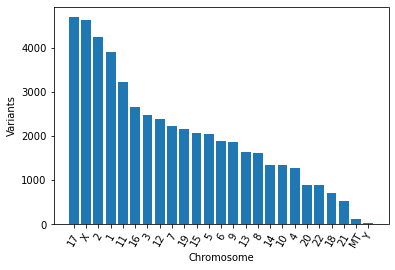

In [182]:
chromosomes = clinvar['GRCh38Chromosome'].value_counts().head(25)

fig, ax = plt.subplots()
ax.bar(chromosomes.index, chromosomes.values)
ax.set_xlabel("Chromosome")
ax.set_ylabel("Variants")
plt.xticks(rotation = 60)
plt.plot()

Text(0, 0.5, 'Variants')

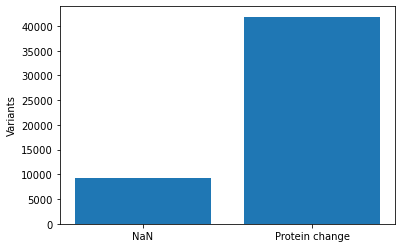

In [191]:
fig, ax = plt.subplots()
ax.bar(["NaN", "Protein change"], [len(clinvar[clinvar['Protein change'].isna()]), len(clinvar[~clinvar['Protein change'].isna()])])
ax.set_ylabel("Variants")